In [146]:
# import packages
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from itertools import combinations

# 1. Preprocess the dataset: project_adult.csv & project_validation_inputs.csv
-  Handle missing values.
-  Encode categorical features.
- Standardize numerical features.

- added in the second data file but does that mean that we don't need to test/train split?

In [147]:
# Reading in the training data

file_path = 'project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  capital-ga

In [148]:
# Reading in the test data

file_path = 'project_validation_inputs.csv'

try:
    df_test = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df_test.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'project_validation_inputs.csv'. First 5 rows:
        0    1          2       3             4              5   \
0      NaN  age  workclass  fnlwgt     education  education-num   
1  14160.0   27    Private  160178  Some-college             10   
2  27048.0   45  State-gov   50567       HS-grad              9   
3  28868.0   29    Private  185908     Bachelors             13   
4   5667.0   30    Private  190040     Bachelors             13   

                   6                  7              8      9       10  \
0      marital-status         occupation   relationship   race     sex   
1            Divorced       Adm-clerical  Not-in-family  White  Female   
2  Married-civ-spouse    Exec-managerial           Wife  White  Female   
3  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
4       Never-married  Machine-op-inspct  Not-in-family  White  Female   

             11            12              13              14  
0  capital-gain  capi

In [149]:
display(df_test.shape)
display(df.shape)

(6514, 15)

(26049, 16)

In [150]:
# Count "?" in each column
question_counts = (df == "?").sum()
print(question_counts)

0        0
1        0
2     1447
3        0
4        0
5        0
6        0
7     1454
8        0
9        0
10       0
11       0
12       0
13       0
14     458
15       0
dtype: int64


In [151]:
# process and standardize data
def preprocess_data(df):

    # Drop the first column (seems like just a random index) and first row (column names)
    df = df.iloc[1:, 1:]
    
    # correct column names
    new_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
    df.columns = new_column_names

    # Handle missing values
    df.replace('?', np.nan, inplace=True)

    df['workclass'] = df['workclass'].fillna(df['workclass'].mode()[0])
    df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])
    df['native-country'] = df['native-country'].fillna(df['native-country'].mode()[0])

    print(f"Total missing values in the DataFrame: {df.isnull().sum().sum()}") 

    # Binarize the target variable
    df['class'] = df['class'].apply(lambda x: 1 if x == '>50K' else 0)

    # keep track of rows indexes to connect X and y
    df = df.reset_index(names=['original_index'])

    #Columns to encode
    columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']
     
    # Encode categorical features
    #df = pd.get_dummies(df, columns = columns_to_encode, dtype = int)

    
    # Apply LabelEncoder to each column
    label_encoders = {}
    for col in columns_to_encode:    
        le = LabelEncoder()    
        df[col] = le.fit_transform(df[col])    
        label_encoders[col] = le  

    # change data types
    df = df.apply(pd.to_numeric, errors='coerce')


    # Separate features and target
    X = df.drop(columns=['class'], axis=1)
    y = df[['original_index','class']]

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    display(df.head())
    
    # Check means and standard deviations
    print("Means after scaling:\n", X[numeric_cols].mean())
    print("\nStandard deviations after scaling:\n", X[numeric_cols].std())

    return X, y

In [152]:
# preprocess training data
X, y = preprocess_data(df)

Total missing values in the DataFrame: 0


original_index  age  workclass  fnlwgt  education  education-num  \
0               1   33          1  198183          9             13   
1               2   36          3   86459          8             11   
2               3   58          5  203039          6              5   
3               4   21          3  180190          8             11   
4               5   27          3  279872         15             10   

   marital-status  occupation  relationship  race  sex  capital-gain  \
0               4           9             1     4    0             0   
1               2           3             0     4    1             0   
2               5           2             1     4    1             0   
3               2           4             0     4    1             0   
4               0           7             1     4    1             0   

   capital-loss  hours-per-week  native-country  class  
0             0              50              38      1  
1          1887              50              38      1  
2             0              40              38      0  
3             0              46              38      0  
4             0              40              38      0

Means after scaling:
 age               1.636692e-16
fnlwgt            1.936753e-17
education-num    -6.137597e-18
capital-gain     -2.427760e-17
capital-loss     -2.836934e-17
hours-per-week   -2.373204e-16
dtype: float64

Standard deviations after scaling:
 age               1.000019
fnlwgt            1.000019
education-num     1.000019
capital-gain      1.000019
capital-loss      1.000019
hours-per-week    1.000019
dtype: float64


In [153]:
# process and standardize data
def preprocess_test_data(df):

    # Drop the first column (seems like just a random index) and first row (column names)
    df = df.iloc[1:, 1:]
    
    
    # correct column names
    new_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
    df.columns = new_column_names

    # Handle missing values
    df.replace('?', np.nan, inplace=True)

    df['workclass'] = df['workclass'].fillna(df['workclass'].mode()[0])
    df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])
    df['native-country'] = df['native-country'].fillna(df['native-country'].mode()[0])

    print(f"Total missing values in the DataFrame: {df.isnull().sum().sum()}") 

    # keep track of rows indexes to connect X and y
    df = df.reset_index(names=['original_index'])

    # Columns to encode
    columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']
     
    # Encode categorical features
    #df = pd.get_dummies(df, columns = columns_to_encode, dtype = int)

    
    # Apply LabelEncoder to each column
    label_encoders = {}
    for col in columns_to_encode:    
        le = LabelEncoder()    
        df[col] = le.fit_transform(df[col])    
        label_encoders[col] = le 

    # change data types
    df = df.apply(pd.to_numeric, errors='coerce')


    # Separate features and target
    X = df

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    display(df.head())
    
    # Check means and standard deviations
    print("Means after scaling:\n", X[numeric_cols].mean())
    print("\nStandard deviations after scaling:\n", X[numeric_cols].std())

    return X

In [154]:
# preprocess test data
X_df_test = preprocess_test_data(df_test)

Total missing values in the DataFrame: 0


original_index       age  workclass    fnlwgt  education  education-num  \
0               1 -0.851191          2 -0.277853         15      -0.031693   
1               2  0.469374          5 -1.304090         11      -0.421896   
2               3 -0.704461          2 -0.036955          9       1.138915   
3               4 -0.631097          2  0.001731          9       1.138915   
4               5 -0.704461          4 -0.004766         15      -0.031693   

   marital-status  occupation  relationship  race  sex  capital-gain  \
0               0           0             1     4    0     -0.147225   
1               2           3             5     4    0     -0.147225   
2               2           3             0     2    1     -0.147225   
3               4           6             1     4    0     -0.147225   
4               0           2             1     4    1      0.128973   

   capital-loss  hours-per-week  native-country  
0     -0.211274       -0.212164              36  
1     -0.211274       -0.051009              36  
2     -0.211274        1.157652              36  
3     -0.211274       -0.051009              36  
4     -0.211274        0.754765              36

Means after scaling:
 age              -7.527629e-17
fnlwgt            1.210966e-16
education-num     1.996458e-16
capital-gain     -2.427388e-17
capital-loss      5.454804e-18
hours-per-week    2.705583e-16
dtype: float64

Standard deviations after scaling:
 age               1.000077
fnlwgt            1.000077
education-num     1.000077
capital-gain      1.000077
capital-loss      1.000077
hours-per-week    1.000077
dtype: float64


# 2. Implement the Perceptron and Adaline algorithms
- Train Perceptron and Adline models (at least AdalineSGD).
- Plot the number of misclassifications (Perceptron) and MSE (Adaline) over epochs.
- Find the accuracy of your best models from both algorithms
- Use best performing models to predict outputs for project_validation_inputs.
- Use provided code to implement scikit-learn’s Perceptron and Adaline algorithms. Find the accuracy on the validation data using your best models for both.

In [155]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
display(X_train.head())

original_index       age  workclass    fnlwgt  education  \
224               225 -1.141752          3  0.197345         11   
9902             9903 -0.042258          3  0.200576         11   
3846             3847 -0.042258          3 -0.120100         15   
6049             6050 -0.701954          1  0.590082         11   
12789           12790  0.690738          5  1.806731         12   

       education-num  marital-status  occupation  relationship  race  sex  \
224        -0.419604               4           0             3     4    1   
9902       -0.419604               2           3             0     4    1   
3846       -0.031277               5           7             1     4    0   
6049       -0.419604               4          10             1     2    0   
12789       1.522029               2           3             0     4    1   

       capital-gain  capital-loss  hours-per-week  native-country  
224       -0.145715     -0.217998       -0.031510              38  
9902      -0.145715     -0.217998        0.292878              38  
3846      -0.145715     -0.217998        1.428237              38  
6049      -0.145715     -0.217998       -0.031510              38  
12789     -0.145715     -0.217998       -0.031510              25

In [157]:
# manual adaline and perceptron implementations

# adaline sgd
class AdalineSGD:
    """ADAptive Linear Neuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)





class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)



In [158]:
feature_cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

In [159]:
#display(X_train.loc[:,feature_cols].head())
display(y_train.loc[:,'class'].head())

224      0
9902     1
3846     0
6049     0
12789    1
Name: class, dtype: int64

Adaline accuracy with n_iter 1 and eta 0.0005: 0.7768
Adaline accuracy with n_iter 1 and eta 0.0003: 0.8056
Adaline accuracy with n_iter 1 and eta 0.0001: 0.8029
Adaline accuracy with n_iter 1 and eta 5e-05: 0.8036
Adaline accuracy with n_iter 1 and eta 3e-05: 0.8010
Adaline accuracy with n_iter 5 and eta 0.0005: 0.7685
Adaline accuracy with n_iter 5 and eta 0.0003: 0.7731
Adaline accuracy with n_iter 5 and eta 0.0001: 0.8056
Adaline accuracy with n_iter 5 and eta 5e-05: 0.8134
Adaline accuracy with n_iter 5 and eta 3e-05: 0.8169
Adaline accuracy with n_iter 10 and eta 0.0005: 0.7743
Adaline accuracy with n_iter 10 and eta 0.0003: 0.7837
Adaline accuracy with n_iter 10 and eta 0.0001: 0.8190
Adaline accuracy with n_iter 10 and eta 5e-05: 0.8182
Adaline accuracy with n_iter 10 and eta 3e-05: 0.8100
Adaline accuracy with n_iter 15 and eta 0.0005: 0.7747
Adaline accuracy with n_iter 15 and eta 0.0003: 0.7731
Adaline accuracy with n_iter 15 and eta 0.0001: 0.7975
Adaline accuracy with n_it

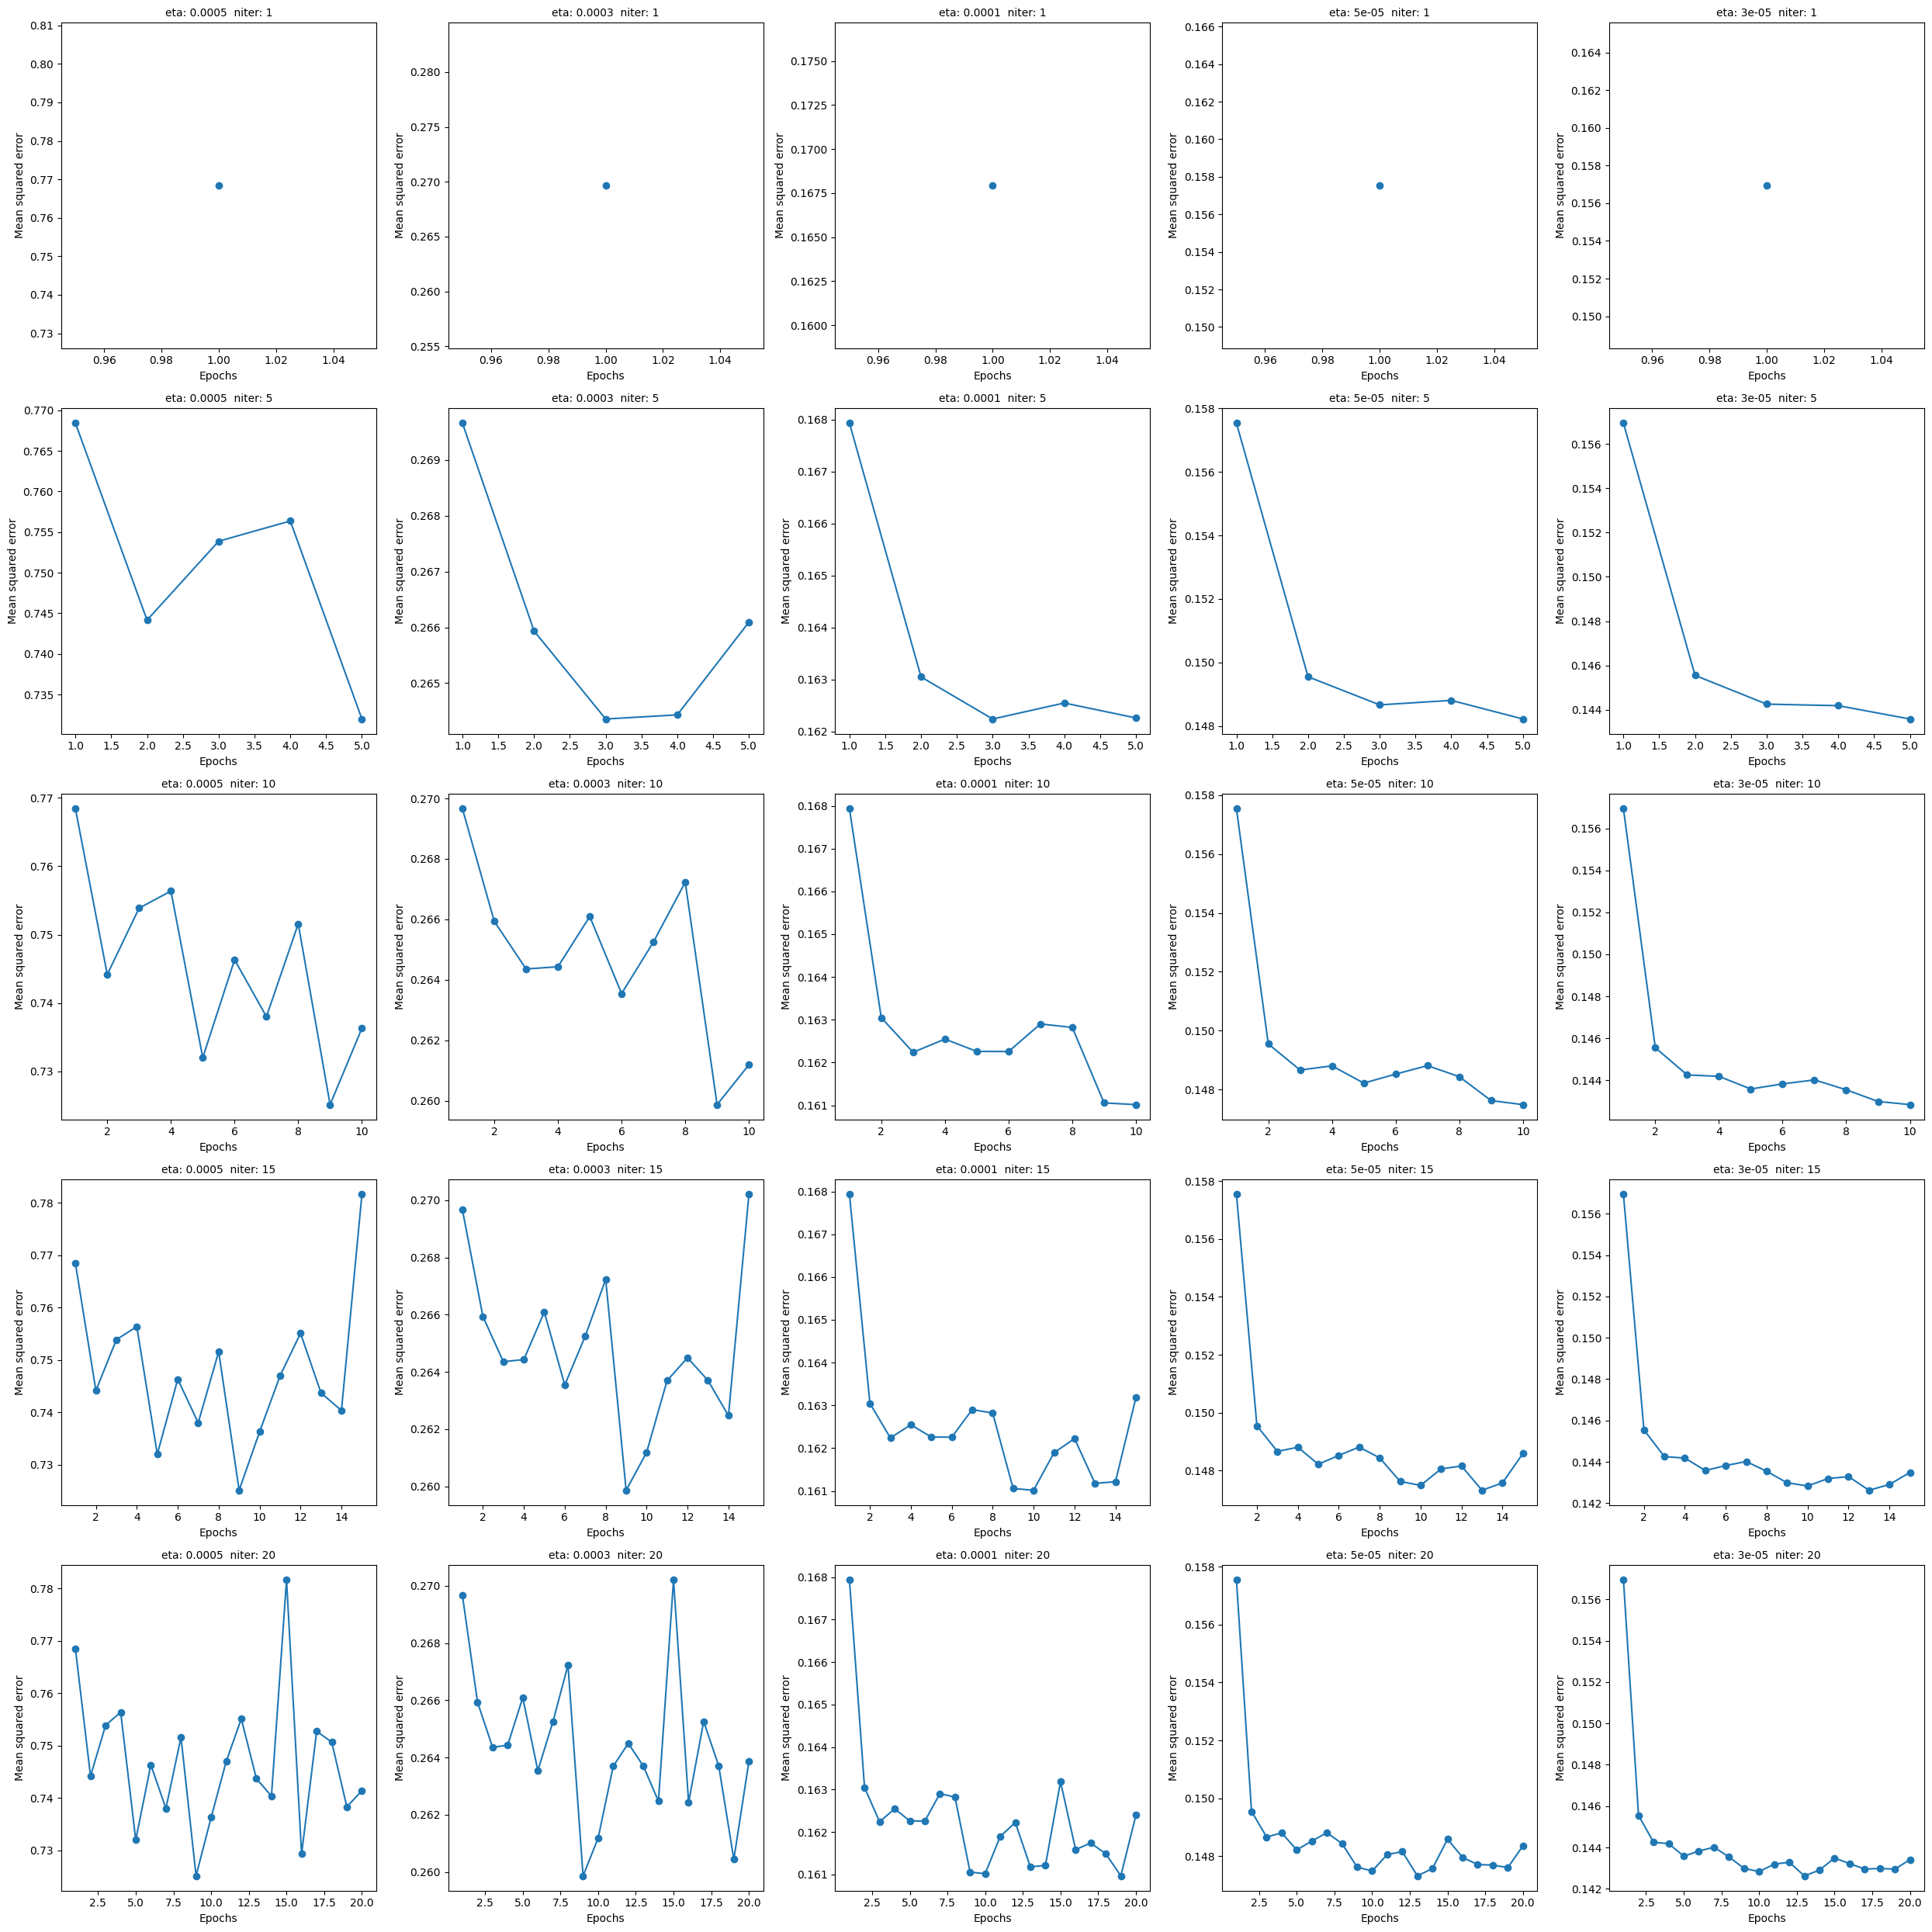


Highest accuracy: 0.8190 with eta 0.0001 and n_iter 10


In [160]:
# adaline sgd

# looking at parameters eta and n_iter
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [0.0005, 0.0003, 0.0001, 0.00005, 0.00003]
list_niter = [1, 5, 10, 15, 20]

best_accuracy = 0
best_combo = (None, None)  # (eta, n_iter)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta=e_temp, shuffle=True, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test.loc[:,feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, y_pred)        
        print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {acc:.4f}")
        #print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

        if acc > best_accuracy:            
            best_accuracy = acc            
            best_combo = (e_temp, n_temp)
    
plt.tight_layout()
plt.show()

print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and n_iter {best_combo[1]}")

In [161]:
display(X_df_test.head())

original_index       age  workclass    fnlwgt  education  education-num  \
0               1 -0.851191          2 -0.277853         15      -0.031693   
1               2  0.469374          5 -1.304090         11      -0.421896   
2               3 -0.704461          2 -0.036955          9       1.138915   
3               4 -0.631097          2  0.001731          9       1.138915   
4               5 -0.704461          4 -0.004766         15      -0.031693   

   marital-status  occupation  relationship  race  sex  capital-gain  \
0               0           0             1     4    0     -0.147225   
1               2           3             5     4    0     -0.147225   
2               2           3             0     2    1     -0.147225   
3               4           6             1     4    0     -0.147225   
4               0           2             1     4    1      0.128973   

   capital-loss  hours-per-week  native-country  
0     -0.211274       -0.212164              36  
1     -0.211274       -0.051009              36  
2     -0.211274        1.157652              36  
3     -0.211274       -0.051009              36  
4     -0.211274        0.754765              36

In [162]:
# Implement best verson of Adaline SGD on test dataset

ada_best = AdalineSGD(n_iter=10, eta=0.0001, shuffle=True, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_ada = ada_best.predict(X_df_test.loc[:,feature_cols].values)


df_ada_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'ada_pred': y_pred_best_ada
})


display(df_ada_pred.head())

#df_ada_pred.to_csv('adaline_predictions.csv', index=False)

original_index  ada_pred
0               1         0
1               2         0
2               3         0
3               4         0
4               5         0

Perceptron accuracy with n_iter 1 and eta 0.0005: 0.7856
Perceptron accuracy with n_iter 1 and eta 0.0003: 0.8265
Perceptron accuracy with n_iter 1 and eta 0.0001: 0.7908
Perceptron accuracy with n_iter 1 and eta 5e-05: 0.7862
Perceptron accuracy with n_iter 1 and eta 3e-05: 0.8061
Perceptron accuracy with n_iter 5 and eta 0.0005: 0.8061
Perceptron accuracy with n_iter 5 and eta 0.0003: 0.7973
Perceptron accuracy with n_iter 5 and eta 0.0001: 0.7958
Perceptron accuracy with n_iter 5 and eta 5e-05: 0.8025
Perceptron accuracy with n_iter 5 and eta 3e-05: 0.7948
Perceptron accuracy with n_iter 10 and eta 0.0005: 0.8046
Perceptron accuracy with n_iter 10 and eta 0.0003: 0.8000
Perceptron accuracy with n_iter 10 and eta 0.0001: 0.8255
Perceptron accuracy with n_iter 10 and eta 5e-05: 0.8271
Perceptron accuracy with n_iter 10 and eta 3e-05: 0.8031
Perceptron accuracy with n_iter 15 and eta 0.0005: 0.7994
Perceptron accuracy with n_iter 15 and eta 0.0003: 0.8244
Perceptron accuracy with n_ite

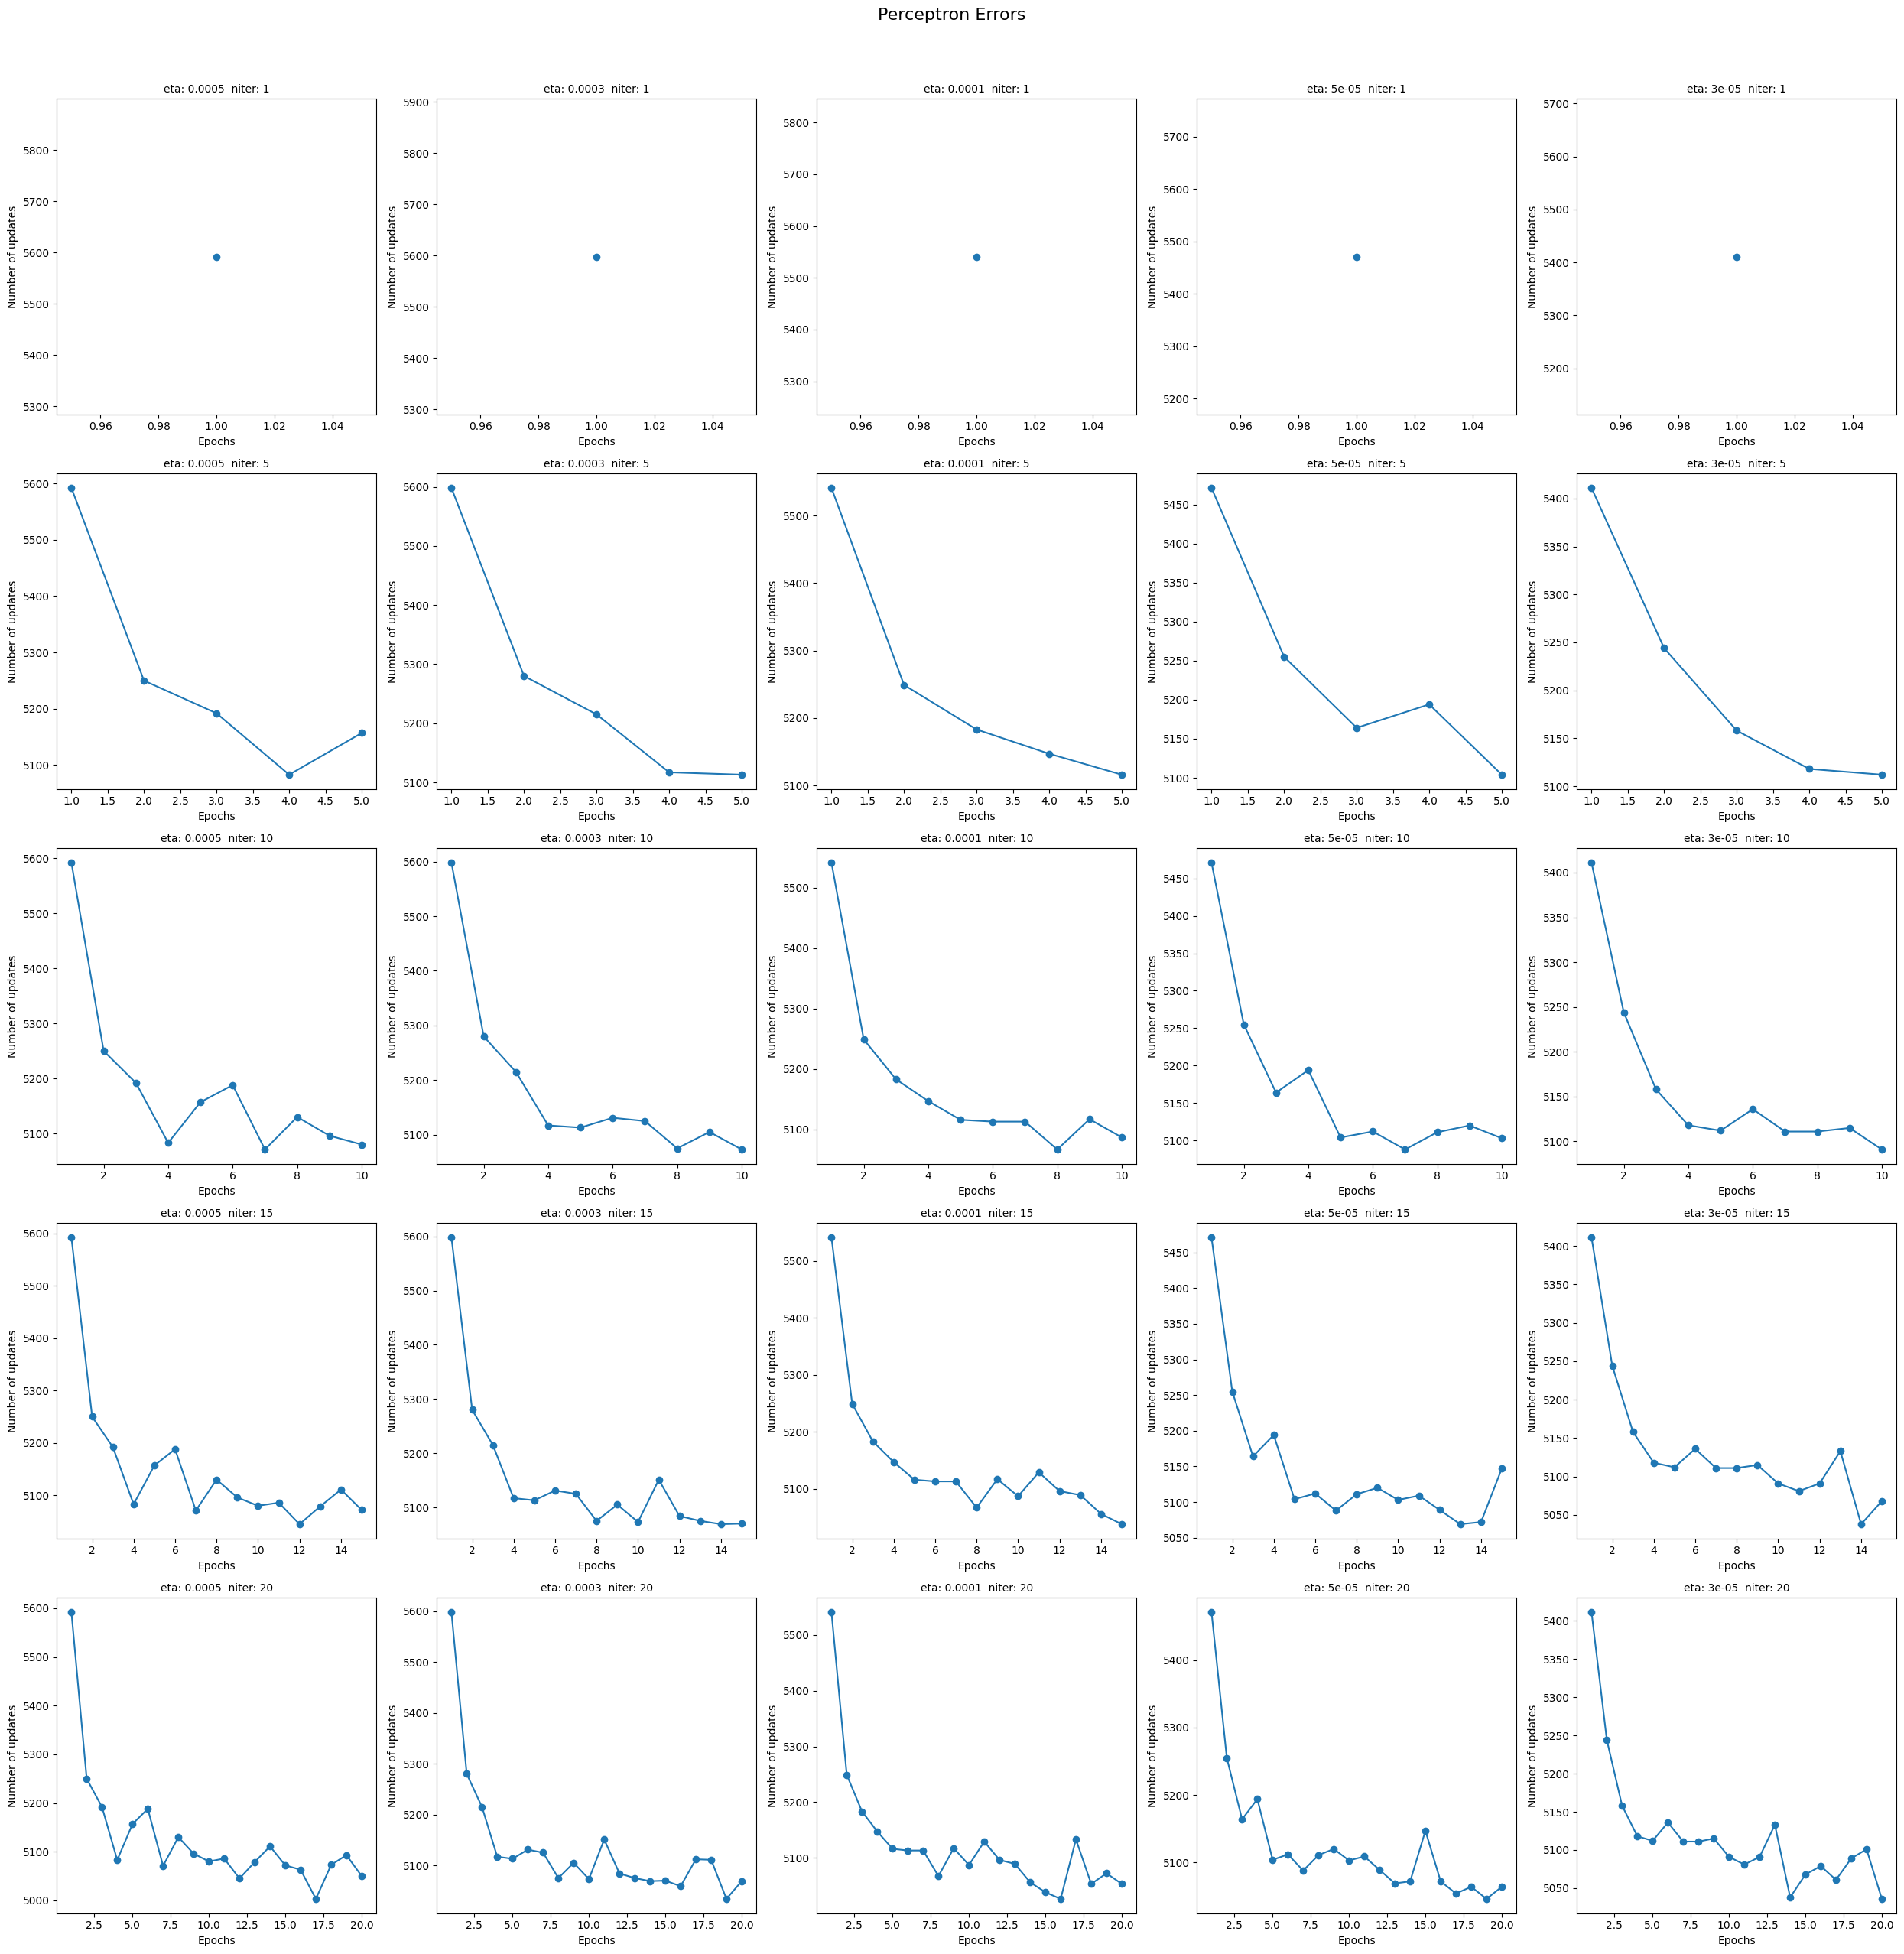


Highest accuracy: 0.8286 with eta 0.0001 and n_iter 15


In [163]:
# perceptron

list_eta = [0.0005, 0.0003, 0.0001, 0.00005, 0.00003]
list_niter = [1, 5, 10, 15, 20]

# Create a new figure for perceptron plots
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
fig.suptitle("Perceptron Errors", fontsize=16, y=1.02)

best_accuracy = 0
best_combo = (None, None)  # (eta, n_iter)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta=e_temp).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
        
        # Also calculate and print accuracy
        y_pred = ppn.predict(X_test.loc[:,feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, y_pred)      
        print(f"Perceptron accuracy with n_iter {n_temp} and eta {e_temp}: {acc:.4f}") 
        #print(f"Perceptron accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

        if acc > best_accuracy:            
            best_accuracy = acc            
            best_combo = (e_temp, n_temp)
    
plt.tight_layout()
plt.show()

print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and n_iter {best_combo[1]}")

In [164]:
# Implement best verson of Perceptron on test dataset

ppn_best = Perceptron(n_iter=15, eta=0.0001).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_ppn = ppn_best.predict(X_df_test.loc[:,feature_cols].values)


df_ppn_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'ppn_pred': y_pred_best_ppn
})


display(df_ppn_pred.head())

#df_ppn_pred.to_csv('perceptron_predictions.csv', index=False)

original_index  ppn_pred
0               1         0
1               2         0
2               3         0
3               4         0
4               5         0

In [165]:

# provided adaline and perceptron

# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.5, max_iter=20, random_state=42)
sk_ppn.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=12, random_state=42)
sk_ada.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ada = sk_ada.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ada):.4f}")

Scikit-learn Perceptron accuracy: 0.8232
Scikit-learn Adaline (SGDClassifier) accuracy: 0.8155


In [166]:
# Sklearn perceptron loop 

list_eta = [0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [10, 15, 20, 25, 30] # starting at 10 due to everything below 10 not reaching convergence

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        sk_ppn = SklearnPerceptron(eta0=e_temp, max_iter=n_temp, random_state=42)

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            sk_ppn = sk_ppn.fit(X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values)

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:, feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, sk_y_pred_ppn)
        print(f"Scikit-learn Perceptron accuracy with max_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_combo = (e_temp, n_temp)
 
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")


⚠️ ConvergenceWarning: max_iter=10 reached before convergence.
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.5: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.3: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.1: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.01: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.001: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.0001: 0.7873
Scikit-learn Perceptron accuracy with max_iter 10 and eta 1e-05: 0.7873
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.5: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.3: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.1: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.01: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.001: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.0001: 0.7873
Scikit-learn 

In [167]:
# Test Best Combo for Convergence - Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.01, max_iter=15, random_state=42)
sk_ppn.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ppn):.4f}")

Scikit-learn Perceptron accuracy: 0.8232


In [168]:
# Implement best verson of Sklearn Perceptron on test dataset
# choosing eta = 0.01 since they all had same accuracy @ max_iter = 15 so this one is the moderate choice of learning rates

skppn_best = SklearnPerceptron(eta0=0.01, max_iter=15, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_skppn = skppn_best.predict(X_df_test.loc[:,feature_cols].values)


df_skppn_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'skppn_pred': y_pred_best_skppn
})


display(df_skppn_pred.head())

#df_skppn_pred.to_csv('sklearn_perceptron_predictions.csv', index=False)

original_index  skppn_pred
0               1           0
1               2           0
2               3           0
3               4           0
4               5           0

In [169]:
# Sklearn perceptron loop using CV just to see what happens

list_eta = [0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [10, 15, 20, 25, 30]

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for n_temp in list_niter:
    for e_temp in list_eta:
        sk_ppn = SklearnPerceptron(eta0=e_temp, max_iter=n_temp, random_state=42)

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            scores = cross_val_score(sk_ppn, X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values, cv=5)
            mean_acc = scores.mean()

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        print(f"CV mean accuracy with max_iter {n_temp} and eta {e_temp}: {mean_acc:.4f}")

        if mean_acc > best_accuracy:
            best_accuracy = mean_acc
            best_combo = (e_temp, n_temp)

print(f"\nBest CV mean accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")



⚠️ ConvergenceWarning: max_iter=10 reached before convergence.
CV mean accuracy with max_iter 10 and eta 0.5: 0.8008
CV mean accuracy with max_iter 10 and eta 0.3: 0.8008
CV mean accuracy with max_iter 10 and eta 0.1: 0.8012
CV mean accuracy with max_iter 10 and eta 0.01: 0.8012
CV mean accuracy with max_iter 10 and eta 0.001: 0.8012
CV mean accuracy with max_iter 10 and eta 0.0001: 0.7517
CV mean accuracy with max_iter 10 and eta 1e-05: 0.7517
⚠️ ConvergenceWarning: max_iter=15 reached before convergence.
CV mean accuracy with max_iter 15 and eta 0.5: 0.7990
CV mean accuracy with max_iter 15 and eta 0.3: 0.7990
CV mean accuracy with max_iter 15 and eta 0.1: 0.8012
CV mean accuracy with max_iter 15 and eta 0.01: 0.8012
CV mean accuracy with max_iter 15 and eta 0.001: 0.8012
CV mean accuracy with max_iter 15 and eta 0.0001: 0.7517
CV mean accuracy with max_iter 15 and eta 1e-05: 0.7517
⚠️ ConvergenceWarning: max_iter=20 reached before convergence.
CV mean accuracy with max_iter 20 and e

In [170]:
# Sklearn adaline loop 

list_eta = [0.3, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [12, 15, 20, 25, 30]

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        sk_ada = SGDClassifier(loss='perceptron', eta0=e_temp, learning_rate='constant', max_iter=n_temp, random_state=42)

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            sk_ada = sk_ada.fit(X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values)

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        sk_y_pred_ada = sk_ada.predict(X_test.loc[:, feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, sk_y_pred_ada)
        print(f"Scikit-learn Adaline accuracy with max_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_combo = (e_temp, n_temp)
 
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")


⚠️ ConvergenceWarning: max_iter=12 reached before convergence.
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.3: 0.7756
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.1: 0.8036
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.05: 0.7927
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.01: 0.7990
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.001: 0.8155
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.0001: 0.7869
Scikit-learn Adaline accuracy with max_iter 12 and eta 1e-05: 0.7900
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.3: 0.7829
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.1: 0.8036
⚠️ ConvergenceWarning: max_iter=15 reached before convergence.
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.05: 0.7883
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.01: 0.7990
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.001: 0.8155
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.

In [171]:
# Test best combo for convergence - Sklearn Adaline
sk_ada = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=12, random_state=42)
sk_ada.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ada = sk_ada.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ada):.4f}")

Scikit-learn Adaline (SGDClassifier) accuracy: 0.8155


In [172]:
# Implement best verson of Sklearn Adaline on test dataset

skada_best = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=12, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_skada = skada_best.predict(X_df_test.loc[:,feature_cols].values)


df_skada_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'skada_pred': y_pred_best_skada
})


display(df_skada_pred.head())

#df_skada_pred.to_csv('sklearn_adaline_predictions.csv', index=False)

original_index  skada_pred
0               1           0
1               2           0
2               3           0
3               4           0
4               5           0

In [173]:
# Sklearn adaline loop using CV just to see what happens

list_eta = [0.3, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [12, 15, 20, 25, 30]

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for n_temp in list_niter:
    for e_temp in list_eta:
        sk_ada = SGDClassifier(loss = 'perceptron', eta0=e_temp, max_iter=n_temp, random_state=42, learning_rate='constant')

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            scores = cross_val_score(sk_ada, X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values, cv=5)
            mean_acc = scores.mean()

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        print(f"CV mean accuracy with max_iter {n_temp} and eta {e_temp}: {mean_acc:.4f}")

        if mean_acc > best_accuracy:
            best_accuracy = mean_acc
            best_combo = (e_temp, n_temp)

print(f"\nBest CV mean accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")

⚠️ ConvergenceWarning: max_iter=12 reached before convergence.
CV mean accuracy with max_iter 12 and eta 0.3: 0.7931
CV mean accuracy with max_iter 12 and eta 0.1: 0.7955
CV mean accuracy with max_iter 12 and eta 0.05: 0.7790
CV mean accuracy with max_iter 12 and eta 0.01: 0.7549
CV mean accuracy with max_iter 12 and eta 0.001: 0.7874
CV mean accuracy with max_iter 12 and eta 0.0001: 0.7754
CV mean accuracy with max_iter 12 and eta 1e-05: 0.7546
CV mean accuracy with max_iter 15 and eta 0.3: 0.7922
CV mean accuracy with max_iter 15 and eta 0.1: 0.8035
⚠️ ConvergenceWarning: max_iter=15 reached before convergence.
CV mean accuracy with max_iter 15 and eta 0.05: 0.7975
CV mean accuracy with max_iter 15 and eta 0.01: 0.7549
CV mean accuracy with max_iter 15 and eta 0.001: 0.7874
CV mean accuracy with max_iter 15 and eta 0.0001: 0.7754
CV mean accuracy with max_iter 15 and eta 1e-05: 0.7546
CV mean accuracy with max_iter 20 and eta 0.3: 0.7922
CV mean accuracy with max_iter 20 and eta 0.1:

# 3. Implement Logistic Regression and SVM using scikit-learn
- Train Logistic Regression and SVM models using scikit-learn.
- Find the accuracy of your best models from both algorithms
- Use best performing models to predict outputs for project_validation_inputs.
- Select 2 features and visualize the decision boundaries.

In [174]:
# plot confusion matrix
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [175]:
print(X_train.values.ravel())
print(y_train.shape)

[ 2.25000000e+02 -1.14175192e+00  3.00000000e+00 ... -2.17998077e-01
  7.79460235e-01  3.80000000e+01]
(20838, 2)


In [176]:
print(y_train['class'].value_counts())

class
0    15774
1     5064
Name: count, dtype: int64


In [177]:
# Initialize the model with default parameters.
# For multi-class problems, LogisticRegression uses a one-vs-rest strategy by default.
# The 'solver' is set to 'lbfgs' as it's a good default for multi-class problems.
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
model.fit(X_train[feature_cols], y_train['class'].values.ravel())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=42)

In [178]:
# Make predictions on the scaled test set.
y_pred = model.predict(X_test[feature_cols])


--- Confusion Matrix ---
[[3750  254]
 [ 645  561]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4004
           1       0.69      0.47      0.56      1206

    accuracy                           0.83      5210
   macro avg       0.77      0.70      0.72      5210
weighted avg       0.82      0.83      0.81      5210



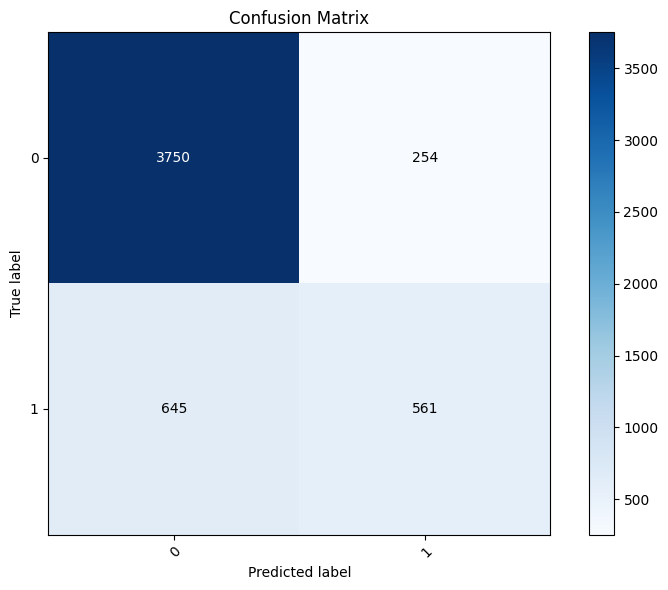

In [179]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test['class'], y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test['class'], y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test['class'])

In [180]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,2-) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': np.logspace(-2, 2, 20),  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=300),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train[feature_cols], y_train['class'].values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=300, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             scoring='accuracy', verbose=1)


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': np.float64(0.06951927961775606)}
Best cross-validation accuracy: 0.8241

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8276

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4004
           1       0.69      0.46      0.55      1206

    accuracy                           0.83      5210
   macro avg       0.77      0.70      0.72      5210
weighted avg       0.82      0.83      0.81      5210


Confusion Matrix:
[[3753  251]
 [ 647  559]]


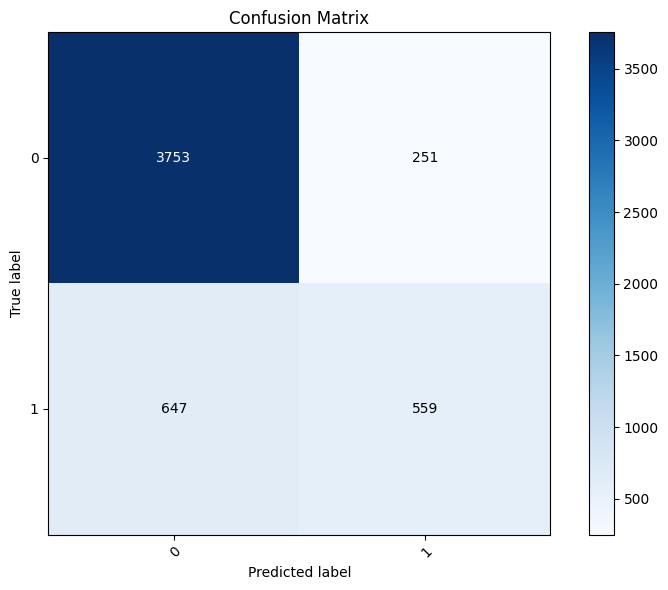

In [181]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test[feature_cols])
final_accuracy = accuracy_score(y_test['class'], final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test['class'], final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test['class'], final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test['class'])

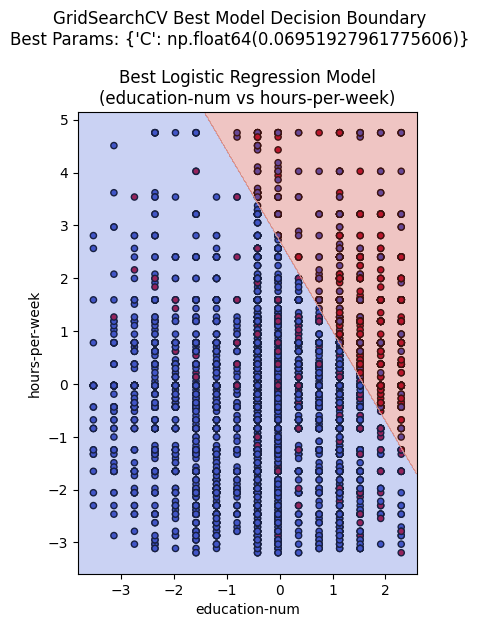

In [182]:
# visualize decision boundary for best log regression model
# numeric columns: 'age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week'

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

f1_name, f2_name = "education-num", "hours-per-week"
X_pair_train = X_train[[f1_name, f2_name]]
X_pair_test = X_test[[f1_name, f2_name]]

y_train_encoded = y_train['class'].values.ravel()
y_test_encoded = y_test['class'].values.ravel()

# Retrain logistic regression on just the two features
plot_model = LogisticRegression(
    solver='lbfgs',
    C=best_params.get('C'),
    random_state=42,
    max_iter=300
)
plot_model.fit(X_pair_train.values, y_train_encoded)

# Create figure/axes first
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the data points
ax.scatter(X_pair_train.iloc[:, 0], X_pair_train.iloc[:, 1],
           c=y_train_encoded, cmap=plt.cm.coolwarm,
           s=20, edgecolors='k')

# Decision boundary grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                     np.linspace(ylim[0], ylim[1], 500))
Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Labels/titles
ax.set_title(f"Best Logistic Regression Model\n({f1_name} vs {f2_name})")
ax.set_xlabel(f1_name)
ax.set_ylabel(f2_name)
ax.set_aspect('equal', adjustable='box')

plt.suptitle(f"GridSearchCV Best Model Decision Boundary\nBest Params: {best_params}", y=1.05)
plt.show()



In [183]:
# Implement best verson of Sklearn Logistic Regression on test dataset

log_reg_best = LogisticRegression(solver='lbfgs', C=best_params.get('C'), random_state=42, max_iter=300).fit(X_train[feature_cols], y_train['class'].values.ravel())
y_pred_best_log_reg = log_reg_best.predict(X_df_test.loc[:,feature_cols])

df_log_reg_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'log_reg_pred': y_pred_best_log_reg
})


display(df_log_reg_pred.head())

#df_log_reg_pred.to_csv('sklearn_log_regression_predictions.csv', index=False)

original_index  log_reg_pred
0               1             0
1               2             0
2               3             0
3               4             0
4               5             0

### SVM

In [184]:
def plot_svm_decision_boundaries_multi_feature(X, y, kernels, title_prefix="", C=1.0, gamma='scale'):
    """
    Plots the decision boundaries for multiple SVM models and multiple feature pairs,
    automatically handling non-numerical target labels and different data types for y.

    Args:
        X (pd.DataFrame): The input features (must have at least 2 columns).
        y (pd.Series or np.ndarray or pd.DataFrame): The target labels.
        kernels (list): A list of kernel strings (e.g., 'linear', 'rbf', 'poly').
        title_prefix (str): A prefix for the plot titles.
        C (float): The regularization parameter.
        gamma (str or float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    """
    # Standardize the y input to a pandas Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        # Convert to Series for consistent handling, and ravel to ensure 1D
        y_series = pd.Series(y.ravel())
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")

    # Check the dtype of the uniform y_series and encode if necessary
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    n_kernels = len(kernels)

    fig, axes = plt.subplots(n_kernels, n_pairs, figsize=(n_pairs * 6, n_kernels * 5),
                             constrained_layout=True)

    # Ensure axes is a 2D array even for a single row/column
    if n_kernels == 1 and n_pairs == 1:
        axes = np.array([[axes]])
    elif n_kernels == 1:
        axes = np.array([axes])
    elif n_pairs == 1:
        axes = axes.reshape(-1, 1)

    for i, kernel in enumerate(kernels):
        for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
            ax = axes[i, j]

            # Select the two features for the current plot
            X_pair = X.iloc[:, [f1_idx, f2_idx]]
            f1_name = X.columns[f1_idx]
            f2_name = X.columns[f2_idx]

            # Train the SVM model on the selected features
            if kernel == 'poly':
                model = SVC(kernel=kernel, C=C, gamma=gamma, degree=3)
            else:
                model = SVC(kernel=kernel, C=C, gamma=gamma)
            
            # FIT THE MODEL WITH .values TO AVOID THE WARNING
            model.fit(X_pair.values, y_encoded)

            # Plot the data points with encoded labels
            ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

            # Create and plot the decision boundary
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                 np.linspace(ylim[0], ylim[1], 500))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
            
            # Highlight the support vectors
            ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='k')
            
            # Set titles and labels
            ax.set_title(f"{title_prefix} {kernel.capitalize()} ({f1_name} vs {f2_name})")
            ax.set_xlabel(f1_name)
            ax.set_ylabel(f2_name)
            ax.set_aspect('equal', adjustable='box')

    plt.show()

In [185]:
def plot_best_svm_decision_boundary(grid_search, X, y):
    """
    Plots the decision boundaries for the best SVM model found by GridSearchCV.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize the y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, pd.Series):
        y_series = y
    elif isinstance(y, np.ndarray):
        y_series = pd.Series(y.ravel())
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        # Ensure y_series is a pandas Series before calling .values
        if isinstance(y_series, np.ndarray):
            y_encoded = y_series
        else:
            y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    
    fig, axes = plt.subplots(1, n_pairs, figsize=(n_pairs * 6, 6), constrained_layout=True)

    # Ensure axes is an array even for a single subplot
    if n_pairs == 1:
        axes = [axes]

    for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
        ax = axes[j]
        
        # Select the two features for the current plot
        X_pair = X.iloc[:, [f1_idx, f2_idx]]
        f1_name = X.columns[f1_idx]
        f2_name = X.columns[f2_idx]

        # Use the best model from GridSearchCV
        model = best_model
        
        # Since the best model was trained on the full dataset, we'll retrain
        # a new instance of it on just the two features for plotting purposes.
        # This is the most reliable way to ensure the decision boundary is correct.
        plot_model = SVC(
            kernel=best_params.get('kernel'),
            C=best_params.get('C'),
            gamma=best_params.get('gamma')
        )
        if best_kernel == 'poly':
            plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
        plot_model.fit(X_pair.values, y_encoded)
        
        # Plot the data points
        ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

        # Create and plot the decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                             np.linspace(ylim[0], ylim[1], 500))
        Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        
        # Highlight the support vectors
        ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # Set titles and labels
        ax.set_title(f"Best Model ({best_kernel.capitalize()} kernel)\n({f1_name} vs {f2_name})")
        ax.set_xlabel(f1_name)
        ax.set_ylabel(f2_name)
        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(f"GridSearchCV Best Model Decision Boundaries\nBest Params: {best_params}", y=1.05)
    plt.show()


--- Confusion Matrix ---
[[3888  116]
 [ 841  365]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4004
           1       0.76      0.30      0.43      1206

    accuracy                           0.82      5210
   macro avg       0.79      0.64      0.66      5210
weighted avg       0.81      0.82      0.78      5210



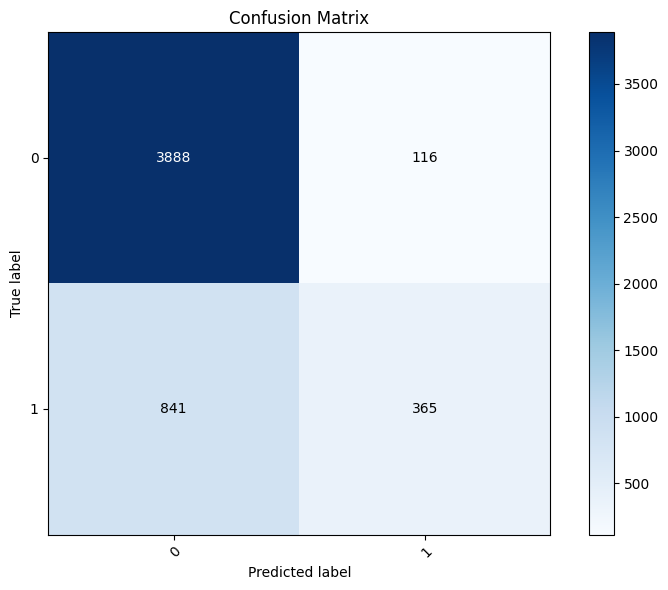

In [186]:
# Train with linear kernel
model_linear = SVC(kernel='linear', C=1)
model_linear.fit(X_train.loc[:, feature_cols].values, y_train['class'].values)

# Make predictions on the scaled test set 
y_pred = model_linear.predict(X_test.loc[:, feature_cols].values)

# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test['class'], y_pred)  
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test['class'], y_pred))  

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test['class'])  

In [187]:
X_train.loc[:, feature_cols]

age  workclass    fnlwgt  education  education-num  \
224   -1.141752          3  0.197345         11      -0.419604   
9902  -0.042258          3  0.200576         11      -0.419604   
3846  -0.042258          3 -0.120100         15      -0.031277   
6049  -0.701954          1  0.590082         11      -0.419604   
12789  0.690738          5  1.806731         12       1.522029   
...         ...        ...       ...        ...            ...   
21575  0.177641          3 -0.743852         11      -0.419604   
5390   0.031041          4  0.312473          9       1.133702   
860   -0.115558          3  0.201327         11      -0.419604   
15795  0.617438          5 -0.088502         15      -0.031277   
23654  0.910636          3 -0.200504         11      -0.419604   

       marital-status  occupation  relationship  race  sex  capital-gain  \
224                 4           0             3     4    1     -0.145715   
9902                2           3             0     4    1     -0.145715   
3846                5           7             1     4    0     -0.145715   
6049                4          10             1     2    0     -0.145715   
12789               2           3             0     4    1     -0.145715   
...               ...         ...           ...   ...  ...           ...   
21575               2           6             0     4    1     -0.145715   
5390                2          11             0     4    1     -0.145715   
860                 2           5             0     4    1     -0.145715   
15795               2          12             0     2    1     -0.145715   
23654               2           3             0     4    1     -0.145715   

       capital-loss  hours-per-week  native-country  
224       -0.217998       -0.031510              38  
9902      -0.217998        0.292878              38  
3846      -0.217998        1.428237              38  
6049      -0.217998       -0.031510              38  
12789     -0.217998       -0.031510              25  
...             ...             ...             ...  
21575     -0.217998        0.373975              38  
5390      -0.217998       -0.031510              38  
860       -0.217998       -1.329063              38  
15795     -0.217998       -0.031510              38  
23654     -0.217998        0.779460              38  

[20838 rows x 14 columns]

/var/folders/06/7t728qgx7lgc1n3hdwb3gwhw0000gn/T/ipykernel_67848/3541958806.py:21: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_series = pd.Series(y.ravel())


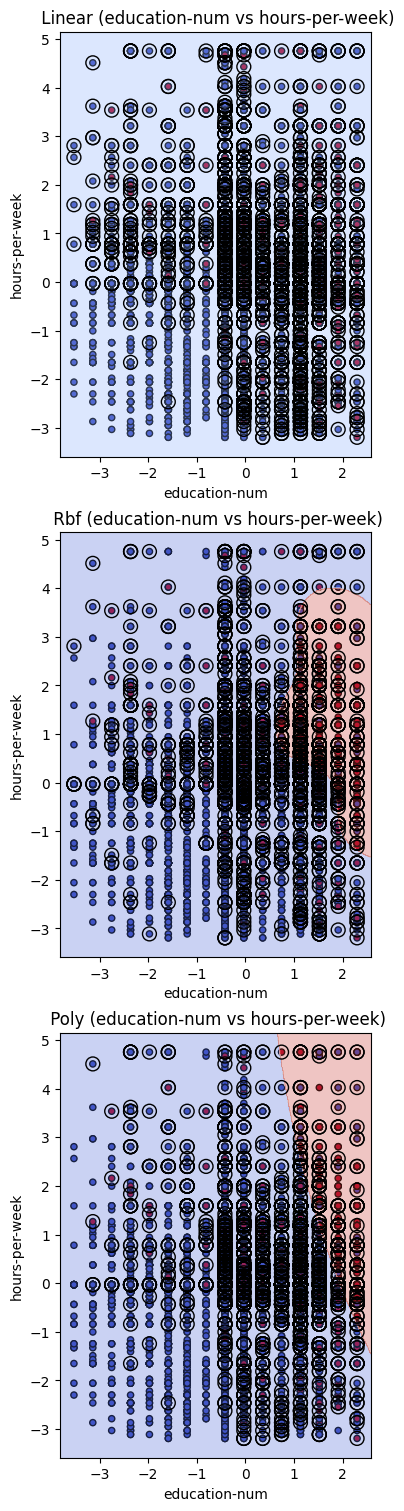

In [188]:
# Plot decision boundaries for different kernels (ONLY 2 FEATURES)
plot_svm_decision_boundaries_multi_feature(X_train.loc[:, ['education-num', 'hours-per-week']], 
                                           y_train['class'], 
                                           kernels=['linear', 'rbf', 'poly'])

In [189]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'], # reduce to 2, removed poly
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=3,                     # 3-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train.loc[:, feature_cols].values, y_train['class'].values)

Starting hyperparameter search. This may take a moment...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [192]:
type(y_test['class'])

pandas.core.series.Series


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8422

 Final evaluation of the best model on the test set...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Final accuracy on test set: 0.8413

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4004
           1       0.70      0.55      0.61      1206

    accuracy                           0.84      5210
   macro avg       0.79      0.74      0.76      5210
weighted avg       0.83      0.84      0.83      5210


Confusion Matrix:
[[3723  281]
 [ 546  660]]


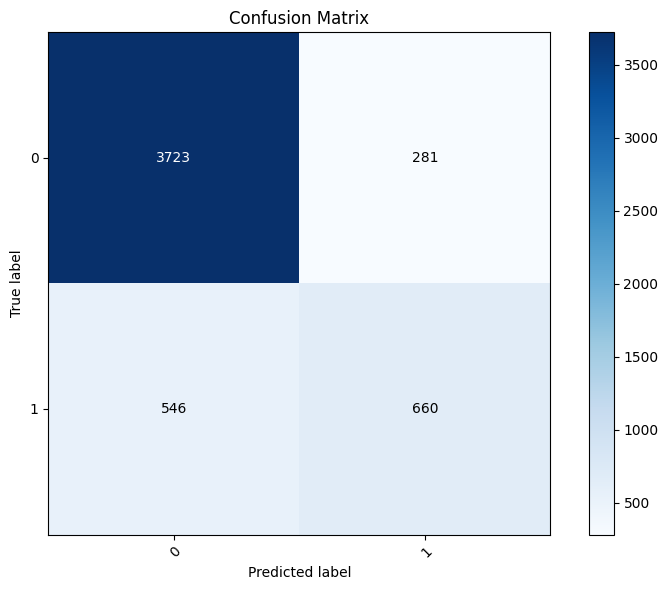

In [193]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test.loc[:, feature_cols])
final_accuracy = accuracy_score(y_test['class'], final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test['class'], final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test['class'], final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test['class'])

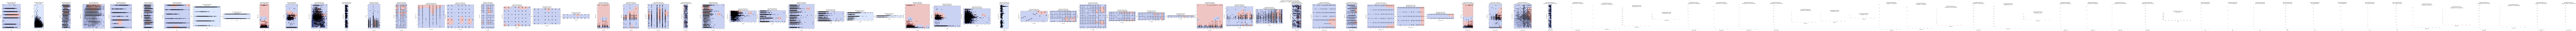

In [ ]:
# TAKES A LONG TIME TO RUN - 2hr
# Plot decision boundaries for selected

#plot_best_svm_decision_boundary(grid_search, X_train.loc[:, feature_cols], y_train['class'])

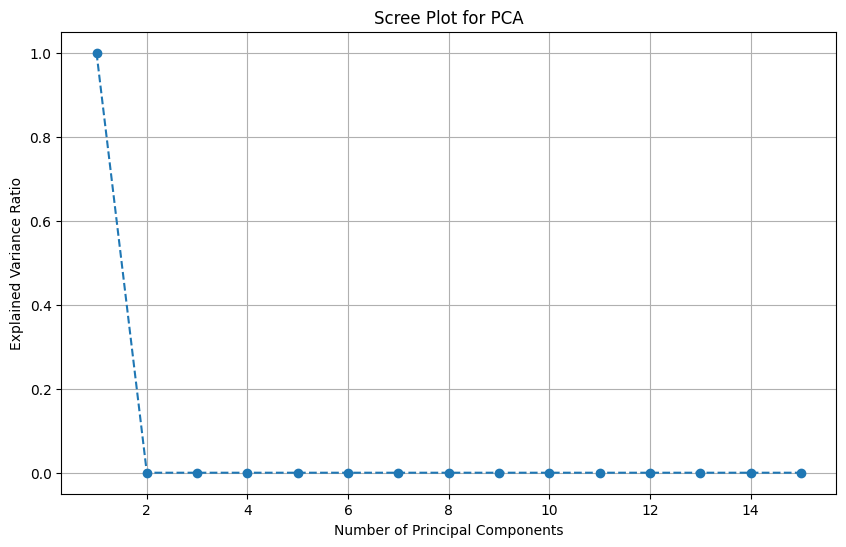

In [195]:
# Perform PCA without assuming a fixed number of components
# By default, PCA will compute all n_features components.
pca = PCA()
pca.fit(X_train) # this is on x train to compare performance 

plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
components = range(1, len(explained_variance_ratio) + 1)
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

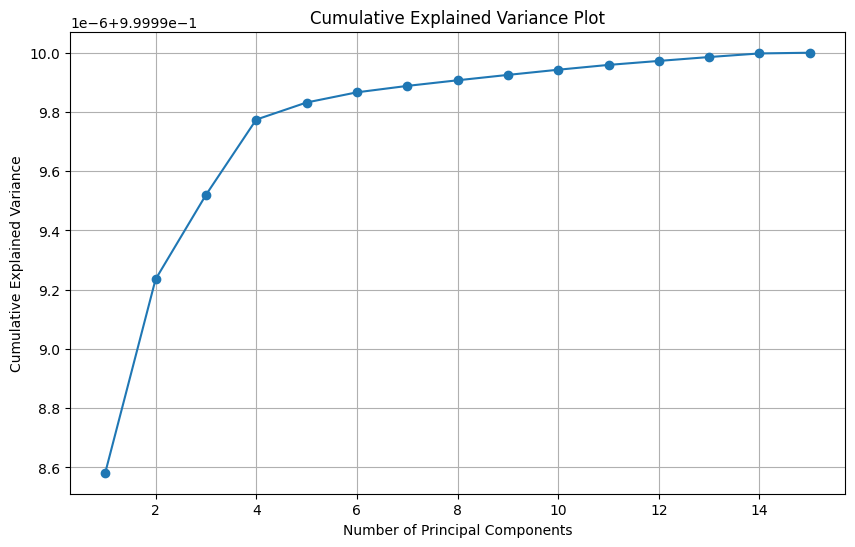

In [196]:
# create the Cumulative Explained Variance Plot
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(components, cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)

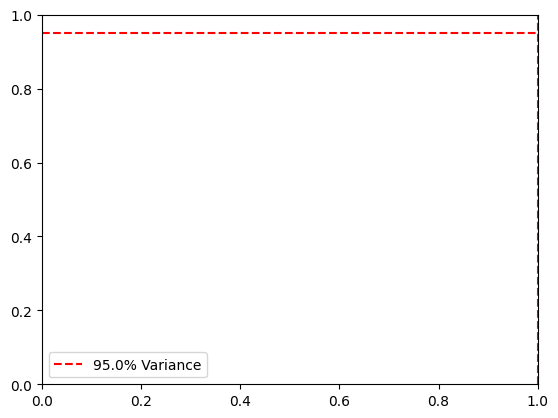

In [197]:
# Highlight a target variance, e.g., 95%
target_variance = 0.95
num_components_95 = np.argmax(cumulative_variance >= target_variance) + 1
plt.axvline(x=num_components_95, color='r', linestyle='--', label=f'{target_variance*100}% Variance')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.legend()
plt.show()

In [198]:
# Find the number of components for a target variance programmatically
num_components_for_95_percent = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components to explain 95% of variance: {num_components_for_95_percent}")

Number of components to explain 95% of variance: 1


In [217]:
# use number of components created in PCA to plot
# Create a DataFrame for the principal components for easier plotting
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train.loc[:, feature_cols]) # Fit and transform training data
X_test_pca = pca.transform(X_test.loc[:, feature_cols]) # Transform the test data using the fitted PCA

pca_df = pd.DataFrame(data=X_train_pca, columns=['principal component 1'])
pca_df['target'] = y_train['class']

In [218]:
# Print the explained variance ratio
# This shows how much of the original data's variance is explained by each component.
print("Explained variance ratio of the components:")
print(pca.explained_variance_ratio_)
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2f}")

Explained variance ratio of the components:
[0.46056985]
Total variance explained: 0.46


In [219]:
# Inspect the principal components_ attribute
# This shows the coefficients of the original features for each component
principal_components_matrix = pca.components_

# Create a DataFrame for better readability
component_df = pd.DataFrame(
    data=principal_components_matrix,
    columns=X.loc[:, feature_cols].columns,
    index=['Principal Component 1']
)

print("Principal Component Loadings:")
print(component_df)

Principal Component Loadings:
                            age  workclass    fnlwgt  education  \
Principal Component 1 -0.000742  -0.000372 -0.010672   0.089064   

                       education-num  marital-status  occupation  \
Principal Component 1       0.019386       -0.008198   -0.009742   

                       relationship      race       sex  capital-gain  \
Principal Component 1     -0.003917  0.016335  0.000186      0.001371   

                       capital-loss  hours-per-week  native-country  
Principal Component 1      0.002436        0.001558        0.995551  


In [227]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'], # reduced for speed
    'gamma': ['scale', 'auto']
}

# Create and fit the GridSearchCV object with the PCA-transformed data
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=2, verbose=2, n_jobs=-1) # only 2 fold for speed
grid_search.fit(X_train_pca, y_train['class'])

# Print the best parameters and score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   3.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   3.3s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=  46.8s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=  46.8s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 1.7min
[CV] END .....................C=1, gamma=auto, kernel=linear; total time= 1.7min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=40.8min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=40.8min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=62.3min
[CV] END ....................C=10, gamma=auto, ke

In [229]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test_pca)

final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrixkx
plot_confusion_matrix(cm, y_test)


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.7570

 Final evaluation of the best model on the test set...


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets